In [1]:
import os
os.chdir("../")

import semiolog as slg

In [2]:
semiotic = slg.Cenematic("en_bnc_test")

SLG [I]: Checking config correctness... Config correct!


100%|██████████| 3/3 [00:00<00:00, 11.29it/s]

SLG [I]: Dataset loaded from disk (TXT files)
SLG [I]: Vocabulary loaded from disk


  0%|          | 0/4 [00:00<?, ?it/s]

SLG [I]: nGrams loaded from disk (['2.json', '3.json', '4.json', '5.json'])


All model checkpoint layers were used when initializing TFBertForMaskedLM.

All the layers of TFBertForMaskedLM were initialized from the model checkpoint at models/en_bnc_test/paradigms/tf_model.h5.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.


SLG [I]: Paradigmatizer loaded from disk


In [3]:
from collections import defaultdict
import string
import itertools
import numpy as np
from tqdm.notebook import tqdm
from math import log
import pandas as pd
import plotly.express as px
import seaborn as sns
from sklearn import decomposition
from sklearn.cluster import KMeans

In [91]:
chars = string.ascii_lowercase+string.digits+" "
chars_dict = {k:i for i,k in enumerate(chars)}

In [92]:
context_functional_distr = defaultdict()

for c_l in tqdm(chars):
    for c_r in chars:

        if c_l == " " and c_r == " ":
            lr_joint = semiotic.vocab.ng2.freq
        elif c_l == " ":
            lr_joint = {k[0:2]:v for k,v in semiotic.vocab.ng3.freq.items() if k[0]==c_r}
        elif c_r == " ":
            lr_joint = {k[1:3]:v for k,v in semiotic.vocab.ng3.freq.items() if k[0]==c_l}
        else:
            lr_joint = {k[1:3]:v for k,v in semiotic.vocab.ng4.freq.items() if k[0]==c_l and k[-1]==c_r}
        

        lr_joint = slg.util.normalize_dict(lr_joint)

        l_marginal = slg.util.marginalize(lr_joint,side="left")
        r_marginal = slg.util.marginalize(lr_joint,side="right")
        x = []
        y = []
        z = []
        
        labels = []

        for l in chars:
            for r in chars:
                
                p_lr = lr_joint.get(l+r,0)
                p_l = l_marginal.get(l,0)
                p_r = r_marginal.get(r,0)

                if p_lr * p_l * p_r == 0:
                    # TODO: Double-check what is convenient to decide in case of 0
                    l_sel_r = r_sel_l = 0
                    l_sol_r = -1
                elif (log(p_lr/(p_l*p_r))/-log(p_lr))<0:
                    # l_sel_r = (p_lr/p_l)-1
                    # r_sel_l = (p_lr/p_r)-1
                    l_sel_r = -(p_lr/p_l)
                    r_sel_l = -(p_lr/p_r)
                else:
                    l_sel_r = p_lr/p_l
                    r_sel_l = p_lr/p_r       

                # if max(l_sel_r,r_sel_l,l_sol_r)>0.1:

                x.append(l_sel_r)
                y.append(r_sel_l)
                # z.append(l_sol_r)
                labels.append(l+r)

        context_functional_distr[c_l+c_r] = [[l_sel_r,r_sel_l] for l_sel_r,r_sel_l in zip(x,y) ]

  0%|          | 0/37 [00:00<?, ?it/s]

In [93]:
labels_dict = {label:i for i,label in enumerate(labels)}

In [94]:
context_tensor = np.array(list(context_functional_distr.values()))
context_matrix = np.reshape(context_tensor, (context_tensor.shape[0],context_tensor.shape[1]*context_tensor.shape[2]))

In [95]:
context_tensor.shape

(1369, 1369, 2)

In [96]:
pca = decomposition.PCA(n_components=3)
pca.fit(context_matrix)
context_PCA = pca.transform(context_matrix)
contexts_kmeans_PCA = KMeans(n_clusters=8, random_state=0).fit(context_PCA)
contexts_kmeans = KMeans(n_clusters=8, random_state=0).fit(context_matrix)

In [97]:
df = pd.DataFrame({
'cat':[str(c) for c in contexts_kmeans_PCA.labels_], 'labels':labels, '1st':context_PCA[:,0], '2nd':context_PCA[:,1], '3rd':context_PCA[:,2]
})
fig_contexts = px.scatter_3d(df, x='1st', y='2nd', z='3rd',
                    color='cat',
                    hover_name= "labels",
                    title="PCA Contexts",
                    width=1000, height=1000,)
fig_contexts.show()

In [98]:
cluster = ["  "]#,"e","i","o","u"] #+ [str(char) for char in range(10)] 
# cluster = [label for cluster,label in zip(contexts_kmeans_PCA.labels_,labels) if cluster == 3]
terms_matrix = context_tensor[[labels_dict[char] for char in cluster]]
terms_matrix = terms_matrix.mean(axis=0)

In [99]:
terms_kmeans = KMeans(n_clusters=6, random_state=0).fit(terms_matrix)

In [101]:
df = pd.DataFrame({
'cat': [str(c) for c in terms_kmeans.labels_],"labels": labels, 'L → R':terms_matrix[:,0], 'L ← R':terms_matrix[:,1],
#  'L ↔ R':terms_matrix[:,2]
})

# thres = 0.05
# df = df[(df['L → R'] > thres) & (df['L ← R'] > thres) & (df['L ↔ R'] > thres)]


fig_terms = px.scatter(df, x='L ← R', y='L → R',# z='L ↔ R',
                    # color='cat',
                    hover_name= "labels",
                    title=f"Functional distribution of characters for contexts {cluster[:5]}...",
                    width=1000, height=1000,)
fig_terms.show()

In [119]:
chars = string.ascii_lowercase+string.digits

def norm_dict(ng_dict:dict):
    val_array = np.array(list(ng_dict.values()))
    # norm = val_array.max()
    # val_array = val_array/norm
    mean = val_array.mean()
    val_array = np.where(val_array>=mean,1,0)
    ng_dict_norm = {k:v for k,v in zip(ng_dict.keys(),val_array)}
    return ng_dict_norm

In [5]:
ng_dicts = defaultdict(dict)

for n in range(2,5):
    ng_dict = {"".join(element):eval(f"semiotic.vocab.ng{n}.freq").get("".join(element),0) for element in itertools.product(*([chars]*n))}
    ng_dicts[n] = ng_dict


In [133]:
ng2_norm = norm_dict(ng_dicts[2])
pairs_index = {"".join(element):i for i, element in enumerate(list(itertools.product(*([chars]*2))))}

In [130]:
connective_data_full = []

for c_l in tqdm(chars):
    for c_r in chars:

        LR = ng2_norm.get(c_l+c_r,0)

        context_dict_1 = {k:v for k,v in ng_dicts[3].items() if k[0]==c_l and k[-1]==c_r}
        context_dict_1 = norm_dict(context_dict_1)

        context_dict_2 = {k:v for k,v in ng_dicts[4].items() if k[0]==c_l and k[-1]==c_r}
        context_dict_2 = norm_dict(context_dict_2)

        connectives_data = []

        for l in chars:
            lR = context_dict_1.get(c_l+l+c_r,0)
            for r in chars:
                Lr = context_dict_1.get(c_l+r+c_r,0)
                lr = context_dict_2.get(c_l+l+r+c_r,0)
                connectives_data.append([lr,lR,Lr,LR])

        connectives_data = np.array(connectives_data)

        connective_data_full.append(connectives_data)

connective_data_full = np.array(connective_data_full)


  0%|          | 0/36 [00:00<?, ?it/s]

In [131]:
connective_data_full.shape

(1296, 1296, 4)

In [137]:
context = "pm"
term = "al"

connective_data_full[pairs_index[context],pairs_index[term]]

array([1, 1, 0, 0])

In [210]:
context = "ts"
term = "an"

cases_dict = defaultdict(list)

for case, key in zip(connective_data_full[pairs_index[context]],pairs_index.keys()):
    cases_dict[tuple(case)]+=[key]

In [211]:
cases_dict.keys()

dict_keys([(0, 1, 1, 1), (0, 1, 0, 1), (1, 1, 0, 1), (1, 1, 1, 1), (1, 0, 1, 1), (0, 0, 0, 1), (0, 0, 1, 1)])

In [212]:
print(cases_dict)

defaultdict(<class 'list'>, {(0, 1, 1, 1): ['aa', 'ae', 'ah', 'ai', 'ao', 'au', 'ay', 'eh', 'eo', 'eu', 'ey', 'hh', 'hs', 'hy', 'ia', 'ih', 'ii', 'io', 'iu', 'iy', 'oh', 'os', 'oy', 'se', 'sh', 'so', 'ss', 'ua', 'uh', 'ui', 'uo', 'us', 'uu', 'uy', 'yh', 'yo', 'ys', 'yu', 'yy'], (0, 1, 0, 1): ['ab', 'ac', 'ad', 'af', 'ag', 'aj', 'ak', 'am', 'ap', 'aq', 'av', 'aw', 'ax', 'az', 'a0', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'a9', 'eb', 'ec', 'ef', 'eg', 'ej', 'ek', 'eq', 'et', 'ev', 'ew', 'ex', 'ez', 'e0', 'e1', 'e2', 'e3', 'e4', 'e5', 'e6', 'e7', 'e8', 'e9', 'hb', 'hc', 'hd', 'hf', 'hg', 'hj', 'hk', 'hl', 'hm', 'hn', 'hp', 'hq', 'hr', 'ht', 'hv', 'hw', 'hx', 'hz', 'h0', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'h7', 'h8', 'h9', 'ib', 'id', 'if', 'ig', 'ij', 'ik', 'ip', 'iq', 'ir', 'iv', 'iw', 'ix', 'iz', 'i0', 'i1', 'i2', 'i3', 'i4', 'i5', 'i6', 'i7', 'i8', 'i9', 'ob', 'oc', 'od', 'og', 'oj', 'ok', 'ol', 'oq', 'ot', 'ov', 'ow', 'ox', 'oz', 'o0', 'o1', 'o2', 'o3', 'o4', 'o5', 'o6', 'o7'

In [168]:
def sim_measure(vec1,vec2):
    return sum(np.sum(abs(vec1-vec2),axis=1)/4)/vec1.shape[0]

similarity_matrix = []
for term1 in tqdm(pairs_index.keys()):
    term1_sim = []
    for term2 in pairs_index.keys():
        vec1 = connective_data_full[:,pairs_index[term1]]
        vec2 = connective_data_full[:,pairs_index[term2]]
        similarity = sim_measure(vec1,vec2)
        term1_sim.append(similarity)
    similarity_matrix.append(term1_sim)

  0%|          | 0/1296 [00:00<?, ?it/s]

In [165]:
similarity_matrix = []
term1= "am"
term1_sim = []
for term2 in tqdm(pairs_index.keys()):
    vec1 = connective_data_full[:,pairs_index[term1]]
    vec2 = connective_data_full[:,pairs_index[term2]]
    similarity = sim_measure(vec1,vec2)
    term1_sim.append(similarity)
similarity_matrix.append(term1_sim)

  0%|          | 0/1296 [00:00<?, ?it/s]

In [148]:
term1 = "am"
term2 = "an"

vec1 = connective_data_full[:,pairs_index[term1]]
vec2 = connective_data_full[:,pairs_index[term2]]

In [164]:
sum(np.sum(abs(vec1-vec2),axis=1)/4)/vec1.shape[0]

0.1572145061728395

In [163]:
vec1.shape[0]

1296

In [156]:
vec1

array([[0, 0, 1, 0],
       [0, 0, 1, 1],
       [0, 0, 0, 1],
       ...,
       [1, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]])

In [154]:
vec2

array([[0, 0, 1, 0],
       [0, 0, 1, 1],
       [0, 0, 1, 1],
       ...,
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]])

In [198]:
raw_ortho = {k:1 for v,k in (zip(similarity_matrix[pairs_index["23"]],pairs_index.keys())) if v<.27}

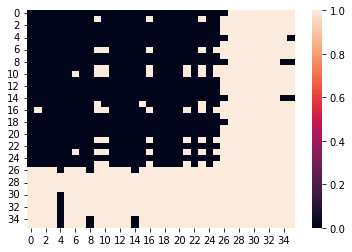

In [199]:
bla = slg.util.matrix_maker(chars,chars,raw_ortho)
import seaborn as sns
ax = sns.heatmap(bla)

In [200]:
ortho_dict = defaultdict(list)
for l,r in raw_ortho:
    ortho_dict[l]+=[r]
print(ortho_dict)

defaultdict(<class 'list'>, {'a': ['1', '2', '3', '4', '5', '6', '7', '8', '9'], 'b': ['j', 'q', 'x', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], 'c': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], 'd': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], 'e': ['1', '2', '3', '4', '5', '6', '7', '8'], 'f': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], 'g': ['j', 'k', 'q', 'x', 'z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], 'h': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], 'i': ['1', '2', '3', '4', '5', '6', '7'], 'j': ['j', 'k', 'q', 'v', 'x', 'z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], 'k': ['g', 'j', 'k', 'q', 'v', 'x', 'z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], 'l': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], 'm': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], 'n': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], 'o': ['1', '2', '3', '4', '5', '6', '7'], 'p': ['j', 'p', 'x', '0', '1', '2', '3', '4', '5', '6', 

In [142]:
similarity_matrix[pairs_index["pl"]]

[array([191, 655, 708,   0]),
 array([227, 655, 254,   0]),
 array([409, 655, 293,   0]),
 array([403, 655, 250,   0]),
 array([172, 655, 710,   0]),
 array([189, 655, 281,   0]),
 array([209, 655, 261,   0]),
 array([136, 655, 315,   0]),
 array([306, 655, 500,   0]),
 array([107, 655, 231,   0]),
 array([158, 655, 236,   0]),
 array([676, 655,   0,   0]),
 array([360, 655, 290,   0]),
 array([690, 655, 255,   0]),
 array([148, 655, 567,   0]),
 array([277, 655, 323,   0]),
 array([101, 655, 220,   0]),
 array([597, 655, 227,   0]),
 array([758, 655, 480,   0]),
 array([863, 655, 370,   0]),
 array([283, 655, 349,   0]),
 array([112, 655, 210,   0]),
 array([217, 655, 254,   0]),
 array([160, 655, 218,   0]),
 array([341, 655, 302,   0]),
 array([131, 655, 223,   0]),
 array([123, 655, 528,   0]),
 array([341, 655, 643,   0]),
 array([274, 655, 641,   0]),
 array([236, 655, 586,   0]),
 array([212, 655, 544,   0]),
 array([179, 655, 548,   0]),
 array([185, 655, 507,   0]),
 array([17

In [114]:
term1 = "ab"
term2 = "cd"

vec1 = connective_data_full[:,pairs_index[term1]]
vec2 = connective_data_full[:,pairs_index[term2]]

In [116]:
vec1

array([[6.89875389e-04, 4.30686490e-03, 1.25650532e-01, 7.27839062e-03],
       [7.86490863e-04, 1.83521621e-02, 1.33356536e-01, 7.67228194e-02],
       [1.72747893e-04, 7.97380279e-03, 3.45058512e-03, 1.37541213e-01],
       ...,
       [0.00000000e+00, 1.21802680e-04, 2.43605359e-04, 3.49329033e-03],
       [0.00000000e+00, 0.00000000e+00, 3.01932367e-04, 6.92131880e-03],
       [0.00000000e+00, 7.69171602e-05, 0.00000000e+00, 4.82842087e-03]])

In [111]:
vec1 = np.array([.75,0,.25,0])
vec2 = np.array([1,1,0,1])

In [112]:
sum(np.abs(vec1-vec2))/4

0.625

In [ ]:
vec1[0].dot(vec2[0])

AttributeError: 'numpy.int64' object has no attribute 'dot'

In [66]:
vec2[0]

array([2.12875834e-04, 1.39170424e-01, 3.49213151e-01, 7.27839062e-03])